In [2]:
### Task is based on image, we need to classify if the cell is infected by malaria cell or not
### This is a binary classification

## CNN

In [3]:
## importing required library

In [4]:
!pip install matplotlib_inline

In [5]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_inline
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [6]:
### for a colored image they have Height, Width and channels = 3 (RBG)
### for a grey scale image, they have height, width and channels =1(black =0, white = 255)

##  Malaria Dataset

In [7]:
import logging
import urllib3

logging.basicConfig(level=logging.INFO)

try:
    urllib3.request("GET", "http://www.tensorflow.org/", retries=2)
except urllib3.exceptions.MaxRetryError:
    pass

INFO:urllib3.poolmanager:Redirecting http://www.tensorflow.org/ -> https://www.tensorflow.org/


In [8]:
## Dataset can be found from https://www.tensorflow.org/datasets/catalog/malaria

In [9]:
dataset,dataset_info = tfds.load('malaria',with_info = True, as_supervised = True, shuffle_files= True, split=['train']) ##with_infi is set true to load dataset_info 

INFO:absl:Load dataset info from C:\Users\avrcb\tensorflow_datasets\malaria\1.0.0
INFO:absl:Reusing dataset malaria (C:\Users\avrcb\tensorflow_datasets\malaria\1.0.0)
INFO:absl:Creating a tf.data.Dataset reading 4 files located in folders: C:\Users\avrcb\tensorflow_datasets\malaria\1.0.0.
INFO:absl:Constructing tf.data.Dataset malaria for split ['train'], from C:\Users\avrcb\tensorflow_datasets\malaria\1.0.0


In [10]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\avrcb\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

In [11]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [12]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

## Split into train test ratio

In [13]:
## take and split are used for same ## This is just an example. If you run this again, please run load dataset again

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset =  tf.data.Dataset.range(10)
#print(list(dataset.as_numpy_iterator()))
#DATASET_SIZE = len(dataset)
#train_dataset =dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
#print(list(train_dataset.as_numpy_iterator()))

#val_test_dataset =dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
#val_dataset= val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
#print(list(val_dataset.as_numpy_iterator()))

#test_dataset= val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
#print(list(test_dataset.as_numpy_iterator()))

In [14]:
def splits(dataset, TRAIN_RATIO, VALIDATION_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    train_dataset =dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset =dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset= val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset= val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset
    

In [15]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [16]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

## Visualizing datasets

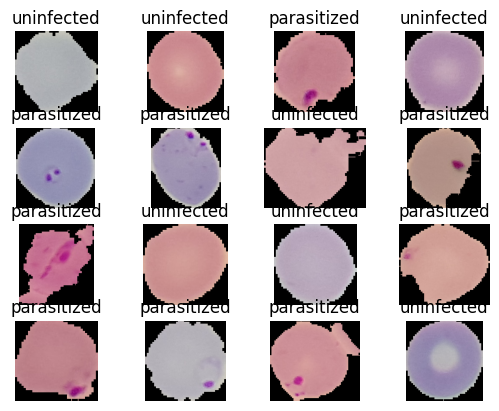

In [17]:
for i,(image, label) in enumerate(train_dataset.take(16)):
    ax= plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

## Data Processing

In [18]:
# resizing image lets say we have image of different heights and weights we make them to standard size
# Normalizing images (X-Xmin)/(Xmax - Xmin)

In [19]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0,label

In [20]:
train_dataset =  train_dataset.map(resize_rescale)
val_dataset =  val_dataset.map(resize_rescale)
val_dataset =  test_dataset.map(resize_rescale)

In [21]:
for image,leabel in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [22]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
model =  tf.keras.Sequential(
    [
        InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides= 1, padding = 'valid', activation = 'sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2 ),
        
        tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides= 1, padding = 'valid', activation = 'sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2 ),
        
        Flatten(),
        Dense(100, activation = 'sigmoid'),
        Dense(10, activation = 'sigmoid'),
        Dense(1, activation = 'sigmoid')
    ]

)
model.summary()




C:\Users\avrcb\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,393 (17.16 MB)

 Trainable params: 4,498,393 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

## Optimizing error

In [26]:
y_true = [0,]
y_pred = [0.2,]
bce = tf.keras.losses.BinaryCrossentropy() ## we use binary cross entropy
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2231435328722>

In [27]:
model.compile(optimizer = Adam(learning_rate = 0.1),
             loss=BinaryCrossentropy())
             #metrics = )

In [28]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 100, verbose= 1)

Epoch 1/100
 81/689 ━━━━━━━━━━━━━━━━━━━━ 1:13 120ms/step - loss: 0.7270

KeyboardInterrupt: 

In [29]:
## we see loss is not varying much so make some changes and run again

In [38]:
model1 =  tf.keras.Sequential(
    [
        InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides= 1, padding = 'valid', activation = 'relu'),
        BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2 ),
        
        tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides= 1, padding = 'valid', activation = 'relu'),
        BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2 ),
        
        Flatten(),
        Dense(100, activation = 'relu'),
        BatchNormalization(),
        Dense(10, activation = 'relu'),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ]

)
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [39]:
model1.compile(optimizer = Adam(learning_rate = 0.1),
             loss=BinaryCrossentropy(),
             metrics = ['accuracy'])

In [40]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose= 1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 265ms/step - accuracy: 0.6553 - loss: 0.6156 - val_accuracy: 0.5067 - val_loss: 1.9036
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 186s 269ms/step - accuracy: 0.8506 - loss: 0.3613 - val_accuracy: 0.4908 - val_loss: 1.6314
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 182s 265ms/step - accuracy: 0.9154 - loss: 0.2555 - val_accuracy: 0.5038 - val_loss: 0.7794
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 184s 267ms/step - accuracy: 0.7048 - loss: 0.5575 - val_accuracy: 0.8157 - val_loss: 0.7001
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 181s 262ms/step - accuracy: 0.9330 - loss: 0.2124 - val_accuracy: 0.5161 - val_loss: 1.2622
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 184s 267ms/step - accuracy: 0.9418 - loss: 0.1786 - val_accuracy: 0.9398 - val_loss: 0.1840
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 185s 268ms/step - accuracy: 0.9480 - loss: 0.1672 - val_accuracy: 0.9416 - val_loss: 0.2103
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 186s 271ms/step - accuracy: 0.9530 -